# D213 - Advanced Data Analytics
### Task 2: Sentiment Analysis Using Neural Networks
___


## Part I: Research Question
### A1: Research Question


One research question that is relevant to the organizational situation that we hope to address in the following neural network sentiment analysis is:
 - Is it possible to predict the positive or negative sentiment of a review based on the text of the review to a relatively reliable degree?

### A2: Objectives And Goals


The primary objective of this analysis is to construct a neural network model that can, to a reasonable extent, accurately classify the positive or negative sentiment of a given IMDB movie review based on the text. Ancillary to that objective is the exploration of different neural network architectures and hyperparameters to determine which combination yields the best results based on our dataset and purpose.


### A3: Prescribed Network


One type of neural network that can be used to perform a text classification task is a simple `Feedforward Neural Network`. However, due to the model's inability to capture the sequential or contextual information of the text, it is not quite as effective as other models such as `Long Short-Term Memory` (`LSTM`) models which are a type of `Recurrent Neural Network` (`RNN`). With `LSTM` models, the model is capable of capturing that critical additional information in the text and thus is able to perform better on text classification tasks.


## Part II: Data Preparation


### B1: Data Exploration


 - Presence of unusual characters (e.g., emojis, non-English characters, etc.)
 - Vocabulary size
 - Proposed word embedding length
 - Statistical justification for the chosen maximum sequence length

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import tensorflow as tf

# Load in IMDB dataset
df = pd.read_csv('./data/imdb_labelled.txt', sep='\t+', header=None, names=['review', 'sentiment'], engine='python')
df

,review,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
...,...,...
995,I just got bored watching Jessice Lange take h...,0
996,"Unfortunately, any virtue in this film's produ...",0
997,"In a word, it is embarrassing.",0
998,Exceptionally bad!,0


In [3]:
# Show sentiment distribution (should be 50/50 as described in the data dictionary)
df['sentiment'].value_counts()

0    500
1    500
Name: sentiment, dtype: int64

Text(0, 0.5, 'Frequency')

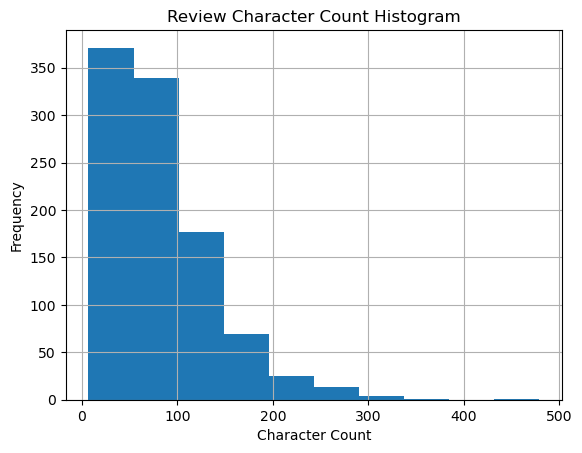

In [4]:
# Create a histogram of reviews by total char lengths
char_hist = df['review'].str.len().hist()
char_hist.set_title('Review Character Count Histogram')
char_hist.set_xlabel('Character Count')
char_hist.set_ylabel('Frequency')

In [5]:
# Get summary statistics of review character lengths
df.review.str.len().describe(percentiles=[.1, .25, .5, .75, .9]).to_frame().T

,count,mean,std,min,10%,25%,50%,75%,90%,max
review,1000.0,82.272,56.286039,7.0,26.0,41.0,68.0,109.0,156.1,479.0


Let's observe what kind of non-standard characters are contained in the reviews. We will simply strip out alphanumeric characters and whitespace, leaving everything else and take a look at the first 20 records.

In [6]:
# Show some of the special characters in the contained in the reviews text
df['review'].str.replace(r'([\w|\s]+)', '', regex=True).to_frame().head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
review,",,-,,.","-,.","&,---.",.,.,",,...','.",.,",.",.,.,.,"',.",.,.,""""".",",.",",.","',,,-,,,-.","'"".","""."


### B2: Tokenization


Prior to any additional steps, we're going to split our dataset into training, validation, and testing sets and do the rest of the data preparation/exploration on the training set. 

In [7]:
# Create a custom function to split data into train, validation, and test sets
def train_val_test_split(X, y, val_size=0.10, test_size=0.10, rand_seed=42):
    """
    Splits data into train, validation, and test sets.
    
    Args:
        X (pd.Series): Series of features
        y (pd.Series): Series of labels
        val_size (float): Proportion of data to use for validation set
        test_size (float): Proportion of data to use for test set
        rand_seed (int): Random seed for reproducibility
    
    Returns:
        Six pd.Series objects: X_train, X_val, X_test, y_train, y_val, y_test corresponding to
        the train, validation, and test sets for the features and labels respectively.
    """
    df = pd.DataFrame({X.name: X, y.name: y})
    
    val_int = int(val_size*len(df))
    test_int = int(test_size*len(df))
    
    train_split = len(df) - val_int - test_int
    val_split = len(df) - test_int
    
    shuf = df.sample(frac=1, random_state=rand_seed) # Shuffle rows
    
    X_train = shuf.iloc[:train_split][X.name]
    X_val = shuf.iloc[train_split:val_split][X.name]
    X_test = shuf.iloc[val_split:][X.name]
    y_train = shuf.iloc[:train_split][y.name]
    y_val = shuf.iloc[train_split:val_split][y.name]
    y_test = shuf.iloc[val_split:][y.name]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Split data into train, validation, and test sets
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df.review, df.sentiment)

Next, we will process the review text by creating an input layer using the TextVectorization module from the TensorFlow library. This layer will tokenize our text, transforming the reviews into sequences of integers representing each word. The module is set up with max_tokens=5000, limiting our analysis to the 5000 most common words to maintain a manageable vocabulary size. 

The parameter output_sequence_length=150 ensures that all sequences are the same length, which is a necessity with our neural network. This sequence length is sufficient to cover the majority of the reviews without being overly long, thus reducing computation time and complexity. Futhermore, the EDA above indicates that the character count of reviews rarely exceeds ~150. Therefore, setting a max sequence length of 150 is more than sufficient given that nearly all tokens will be greater than 1 character in length. The TextVectorization process also converts all text to lower case and removes punctuation, making the text analysis more efficient and the model training process more accurate. Not to mention the fact that it is quite a convenience in the preprocessing phase.

In [8]:
# Use TextVectorization to create an input layer for the model that converts text to sequences of integers
vectorizer = tf.keras.layers.TextVectorization(max_tokens=5000, output_sequence_length=150)

# Fit the vectorizer to the training data
vectorizer.adapt(X_train.values)

Following on from tokenization, let's return to the question of vocabulary size from above. Now that we have adapted our training data, we can get our vocab size.

In [11]:
# Explore an example of the embeddings created for individual tokens by the vectorizer
vectorizer(['The movie was great!']).numpy()

array([[ 2, 13, 12, 50,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0]])

In [9]:
print(f'Vocab size : {vectorizer.vocabulary_size()}')
vocab = vectorizer.get_vocabulary()
print(f"Top 20 vocab items: {vocab[:20]}")

Vocab size : 2720
Top 20 vocab items: ['', '[UNK]', 'the', 'and', 'a', 'of', 'is', 'this', 'i', 'it', 'to', 'in', 'was', 'movie', 'that', 'film', 'for', 'as', 'with', 'but']


In [ ]:
sample_text = ["This movie was fantastic!"]
sample_text_vectorized = vectorizer(sample_text)
print(f"Sample Text: {sample_text}")
print(f"Vectorized Text: {sample_text_vectorized}")
print(f"Tokens: {[vocab[word_index] for word_index in sample_text_vectorized[0][:20]]}")


### B3: Padding Process



### B4: Categories Of Sentiment



### B5: Steps To Prepare The Data



### B6: Prepared Dataset



## Part III: Network Architecture


### C1: Model Summary


In [ ]:
# Build and compile the model
model = tf.keras.models.Sequential()
model.add(vectorizer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)


### C2: Network Architecture



### C3: Hyperparameters



## Part IV: Model Evaluation


### D1: Stopping Criteria



### D2: Training Process



### D3: Fit



### D4: Predictive Accuracy



## Part V: Summary and Recommendations


### E: Code



### F: Functionality



### G: Recommendations



## Part VI: Reporting


### H: Reporting